In [2]:
# ============================================
# Fake vs Real News Detection - Colab Notebook
# Sections covered: 5.4 Feature extraction, 5.5 Model deployment, 5.6 Training procedure
# Author: (Your Name)
# ============================================

# --- 0) Environment & Imports ---
!pip -q install scikit-learn==1.5.2 seaborn

import os, io, zipfile, requests, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


In [3]:
# --- 1) Data Acquisition ---
# We try a direct CSV (GitHub raw of 'fake_or_real_news.csv').
# If it fails (e.g., big-file raw issues), we download a ZIP from the joolsa repo and extract the CSV.

RAW_URL = "https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv"
ZIP_URL = "https://github.com/joolsa/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip"
LOCAL_CSV = "fake_or_real_news.csv"

def download_dataset():
    # Try raw CSV first
    try:
        print("Attempting to download raw CSV...")
        r = requests.get(RAW_URL, timeout=60)
        r.raise_for_status()
        with open(LOCAL_CSV, "wb") as f:
            f.write(r.content)
        print(f"Downloaded: {LOCAL_CSV}")
        return LOCAL_CSV
    except Exception as e:
        print(f"Raw download failed: {e}. Trying ZIP fallback...")
        # Fallback to ZIP
        r = requests.get(ZIP_URL, timeout=60)
        r.raise_for_status()
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(".")
        # The zip contains file named 'fake_or_real_news.csv'
        if os.path.exists(LOCAL_CSV):
            print(f"Extracted: {LOCAL_CSV}")
            return LOCAL_CSV
        else:
            raise RuntimeError("Dataset could not be obtained.")

csv_path = download_dataset()


Attempting to download raw CSV...
Downloaded: fake_or_real_news.csv


Shape: (6335, 4)
Columns: ['id', 'title', 'text', 'label']
      id                                              title  \
0   8476                       You Can Smell Hillary’s Fear   
1  10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608        Kerry to go to Paris in gesture of sympathy   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
label
REAL    3171
FAKE    3164
Name: count, dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits
LogReg best params: {'clf__C': 5.0, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Naive Bayes best params: {'clf__alpha': 0.1}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Random Forest best params: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 3

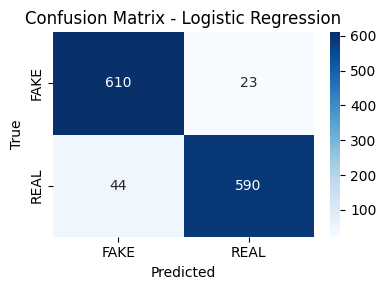


=== Multinomial Naive Bayes ===
Accuracy:  0.9171
Precision: 0.9179
Recall:    0.9164
F1-score:  0.9171

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.92      0.92      0.92       633
        REAL       0.92      0.92      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



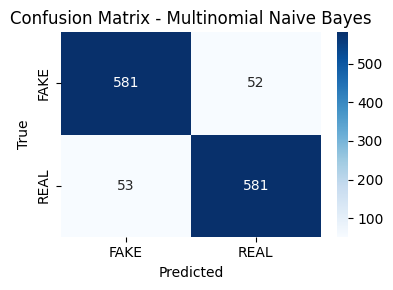


=== Random Forest ===
Accuracy:  0.9171
Precision: 0.9165
Recall:    0.9180
F1-score:  0.9173

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.92      0.92      0.92       633
        REAL       0.92      0.92      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



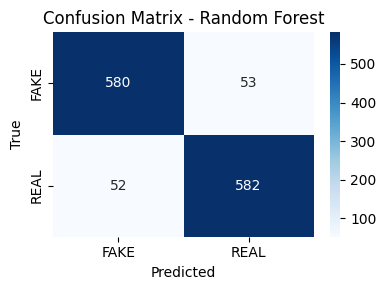


Best model on test set: Logistic Regression
Cross-validated F1 scores: [0.93731343 0.94820717 0.93013972 0.92771084 0.93023256]
Mean F1: 0.9347 Std: 0.0075
Demo prediction: FAKE


In [4]:
# --- 2) Load & Inspect ---
df = pd.read_csv(csv_path)
# Expected columns: 'title', 'text', 'label' (where label is 'FAKE' vs 'REAL')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))

# --- 3) Basic Cleaning ---
# Minimal cleaning appropriate for TF-IDF baseline:
# - Combine title + text
# - Lowercase
# - Remove URLs
# - Remove punctuation
# - Strip extra whitespace

def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = s.lower()
    s = re.sub(r"http\\S+|www\\S+", " ", s)               # remove URLs
    s = s.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    s = re.sub(r"\\s+", " ", s).strip()
    return s

df["doc"] = (df.get("title", "").fillna("") + " " + df.get("text", "").fillna("")).apply(clean_text)
df = df.dropna(subset=["label", "doc"])
df = df[(df["label"] == "FAKE") | (df["label"] == "REAL")]

# Encode labels: FAKE=0, REAL=1
label_map = {"FAKE": 0, "REAL": 1}
df["y"] = df["label"].map(label_map).astype(int)

print(df["label"].value_counts())

# --- 4) Train-Test Split (5.6) ---
X_train, X_test, y_train, y_test = train_test_split(
    df["doc"].values, df["y"].values,
    test_size=0.2, stratify=df["y"].values, random_state=42
)

# --- 5) TF–IDF Feature Extraction (5.4) ---
# Use scikit-learn's TfidfVectorizer with sensible defaults for news text.
tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,           # ignore very common terms
    min_df=5,             # ignore very rare terms
    ngram_range=(1,2),    # unigrams + bigrams for language patterns
)

# We will plug TF-IDF into pipelines for each classifier.

# --- 6) Models & Hyperparameter Tuning (5.5) ---
# 6.1 Logistic Regression (strong baseline for sparse text)
logreg_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, solver="saga"))
])

logreg_param_grid = {
    "clf__C": [0.1, 1.0, 5.0],
    "clf__penalty": ["l2"],  # 'l1' also possible with saga, but try l2 first
}

logreg_gs = GridSearchCV(
    logreg_pipe,
    param_grid=logreg_param_grid,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
logreg_gs.fit(X_train, y_train)
print("LogReg best params:", logreg_gs.best_params_)

# 6.2 Multinomial Naive Bayes (fast + effective for TF-IDF/BoW)
nb_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", MultinomialNB())
])

nb_param_grid = {
    "clf__alpha": [0.1, 0.5, 1.0],
}

nb_gs = GridSearchCV(
    nb_pipe,
    param_grid=nb_param_grid,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
nb_gs.fit(X_train, y_train)
print("Naive Bayes best params:", nb_gs.best_params_)

# 6.3 Random Forest (works but less typical for sparse TF-IDF; still useful for comparison)
rf_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

rf_param_grid = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [None, 30],
    "clf__min_samples_split": [2, 5]
}

rf_gs = GridSearchCV(
    rf_pipe,
    param_grid=rf_param_grid,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_gs.fit(X_train, y_train)
print("Random Forest best params:", rf_gs.best_params_)

# --- 7) Evaluation on Test Set ---
def evaluate_and_report(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {pr:.4f}")
    print(f"Recall:    {rc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return {"name": name, "accuracy": acc, "precision": pr, "recall": rc, "f1": f1}

results = []
results.append(evaluate_and_report("Logistic Regression", logreg_gs.best_estimator_, X_test, y_test))
results.append(evaluate_and_report("Multinomial Naive Bayes", nb_gs.best_estimator_, X_test, y_test))
results.append(evaluate_and_report("Random Forest", rf_gs.best_estimator_, X_test, y_test))

# --- 8) Cross-Validation (5.6) on full training set for the best model ---
# Choose the best by F1 on the holdout test (you may choose accuracy or other metric).
best_model = max(results, key=lambda r: r["f1"])["name"]
model_map = {
    "Logistic Regression": logreg_gs.best_estimator_,
    "Multinomial Naive Bayes": nb_gs.best_estimator_,
    "Random Forest": rf_gs.best_estimator_,
}
print(f"\nBest model on test set: {best_model}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_map[best_model], X_train, y_train, cv=skf, scoring="f1", n_jobs=-1)
print("Cross-validated F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean().round(4), "Std:", cv_scores.std().round(4))

# --- 9) Quick Inference Helper ---
def predict_single(text: str, model):
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    return "REAL" if pred == 1 else "FAKE"

demo_text = "Breaking: President announces new policy to reduce carbon emissions; details from official press release."
print("Demo prediction:", predict_single(demo_text, model_map[best_model]))

# --- 10) Notes:
# - This notebook is lightweight and deployable to low-power contexts due to TF-IDF + linear models.
# - For robustness in production, consider more extensive preprocessing, deduplication, and calibration.
# - If you need per-subject leakage control, restrict